In [1]:
!conda env export > census_environment.yml

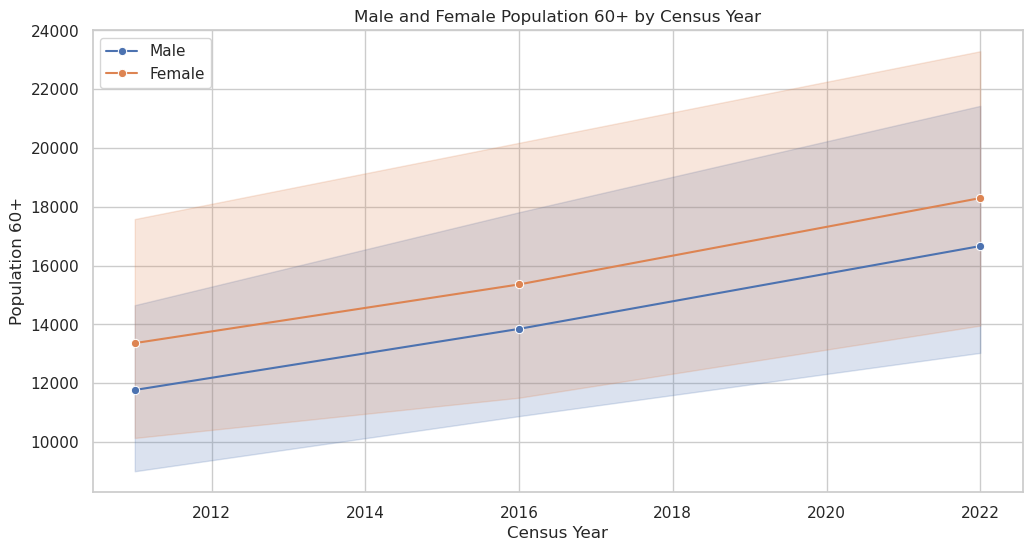

In [2]:

path='/mnt/hgfs/shared/ul_project_Msc_AI/data/census/census population male_female 2011_2016_1022.csv'
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Processing Function
def process_census_data(file_path):
    # Read the data file
    df = pd.read_csv(file_path, sep=',')

    # Function to assign HSE regions to towns/cities in the census data ( currently not correct need more info on HSE regions) 
    def assign_hse_region(county):
        hse_regions = {
            'HSE Dublin and North East': ['Fingal', 'Meath', 'Dublin City' ,'Louth', 'Cavan', 'Monaghan'],
            'HSE Dublin and Midlands': ['Longford', 'Westmeath', 'Offaly', 'Laois', 'Kildare', 'Dún Laoghaire-Rathdown'],
            'HSE Dublin and South East': ['Waterford', 'Kilkenny', 'Carlow', 'Wexford', 'Wicklow', 'South Dublin'],
            'HSE Mid West': ['Limerick', 'Tipperary', 'Clare'],
            'HSE South West': ['Kerry', 'Cork'],
            'HSE West and North West': ['Donegal', 'Sligo', 'Leitrim', 'Roscommon', 'Mayo', 'Galway']
        }
        
        for region, counties in hse_regions.items():
            if any(c in county for c in counties):
                return region
        return 'Unknown'

    # Convert 'Single Year of Age' to numeric, replacing '100 years and over' with 100
    df['Age'] = df['Single Year of Age'].str.extract(r'(\d+)').astype(float)
    df.loc[df['Single Year of Age'] == '100 years and over', 'Age'] = 100

    # Filter for ages 60 and above
    df_60_plus = df[df['Age'] >= 60]

    # Group by region, sex, census year and sum the population
    df_grouped = df_60_plus.groupby(['County and City', 'Sex', 'CensusYear'])['VALUE'].sum().reset_index()

    # Add HSE reg
    df_grouped['HSE Region'] = df_grouped['County and City'].apply(assign_hse_region)

    # Pivot the table to have separate columns for Male and Female
    df_final = df_grouped.pivot_table(
        index=['County and City', 'HSE Region', 'CensusYear'],
        columns='Sex',
        values='VALUE',
        aggfunc='sum'
    ).reset_index()

    df_final.columns.name = None
    df_final = df_final.rename(columns={'Male': 'Male Population 60+', 'Female': 'Female Population 60+'})

    # Calculate total population
    df_final['Total Population 60+'] = df_final['Male Population 60+'] + df_final['Female Population 60+']

    # Reorder columns
    df_final = df_final[['County and City', 'HSE Region', 'CensusYear', 'Male Population 60+', 'Female Population 60+', 'Total Population 60+']]

    return df_final

# Process the data
df_final = process_census_data(path)

# Seaborn Visualization
sns.set(style="whitegrid")


#line plot for Male and Female Population 60+ by year
plt.figure(figsize=(12, 6))
sns.lineplot(x='CensusYear', y='Male Population 60+', data=df_final, label='Male', marker='o')
sns.lineplot(x='CensusYear', y='Female Population 60+', data=df_final, label='Female', marker='o')
plt.title('Male and Female Population 60+ by Census Year')
plt.xlabel('Census Year')
plt.ylabel('Population 60+')
plt.legend()
plt.show()



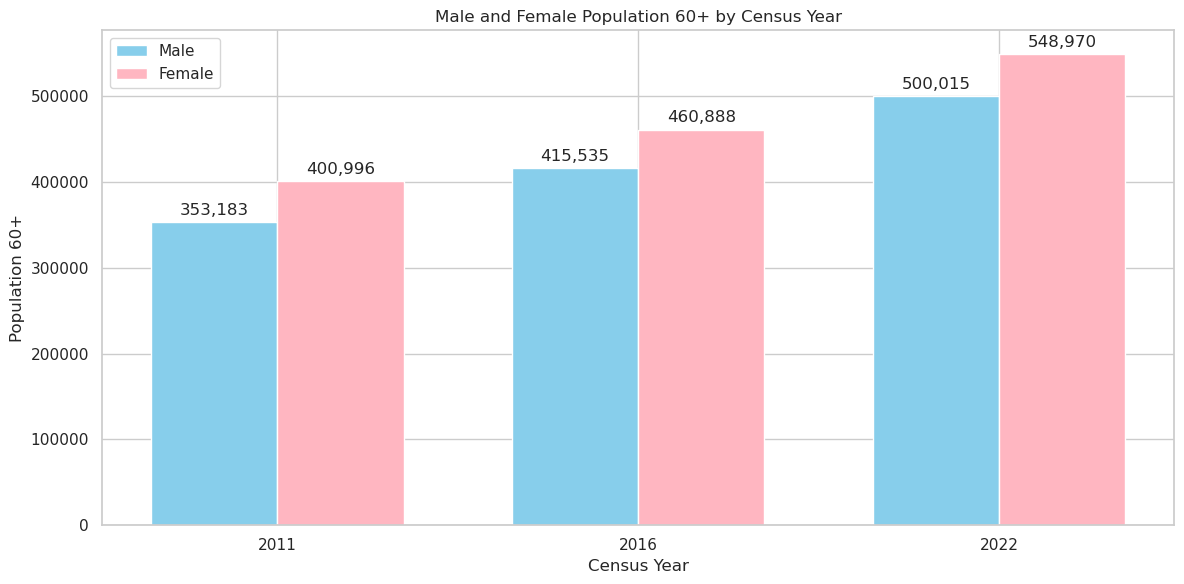

Years: [2011 2016 2022]
Male Population: CensusYear
2011    353183
2016    415535
2022    500015
Name: Male Population 60+, dtype: int64
Female Population: CensusYear
2011    400996
2016    460888
2022    548970
Name: Female Population 60+, dtype: int64


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# separate into  male and female for plotting
years = df_final['CensusYear'].unique()
male_population = df_final.groupby('CensusYear')['Male Population 60+'].sum()
female_population = df_final.groupby('CensusYear')['Female Population 60+'].sum()


fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(years))

# Create the bars
rects1 = ax.bar(x - width/2, male_population, width, label='Male', color='skyblue')
rects2 = ax.bar(x + width/2, female_population, width, label='Female', color='lightpink')
ax.set_title('Male and Female Population 60+ by Census Year')
ax.set_xlabel('Census Year')
ax.set_ylabel('Population 60+')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()

#labels on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:,.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the data (for debugging)
print("Years:", years)
print("Male Population:", male_population)
print("Female Population:", female_population)


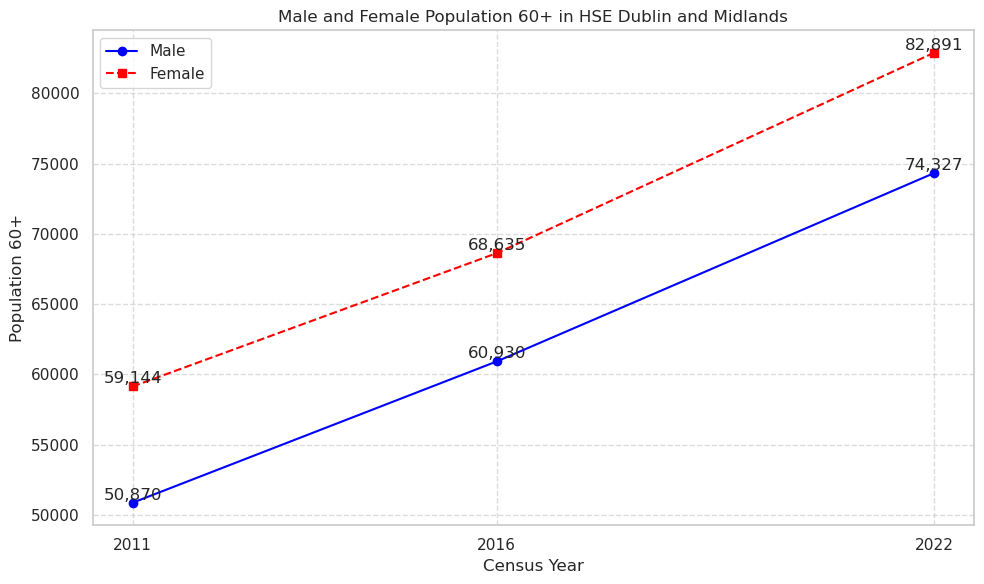

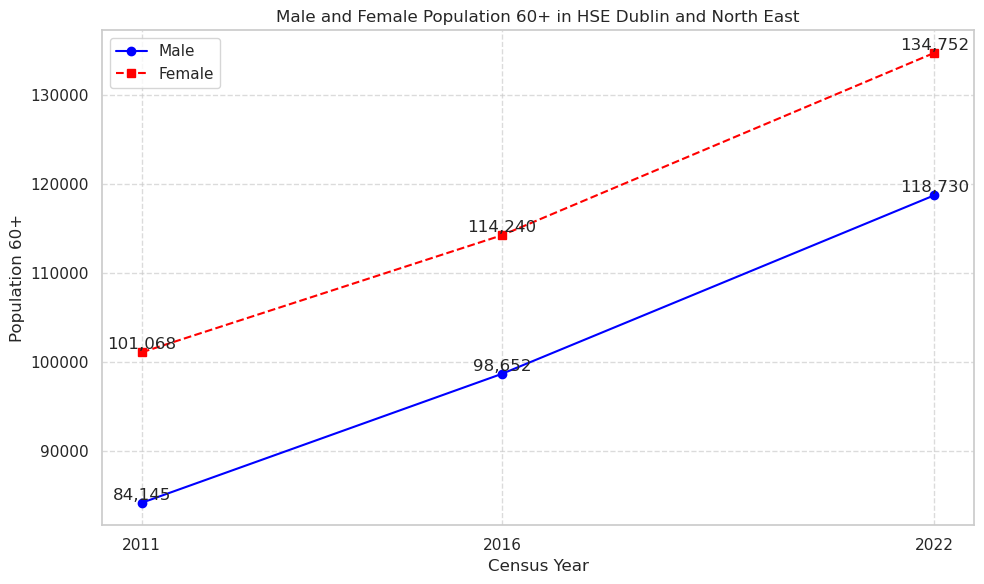

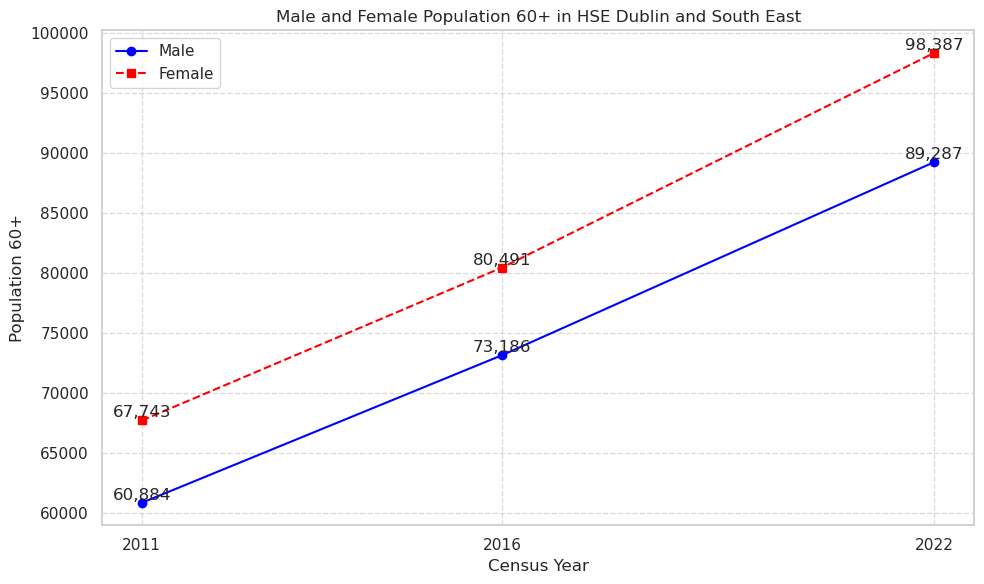

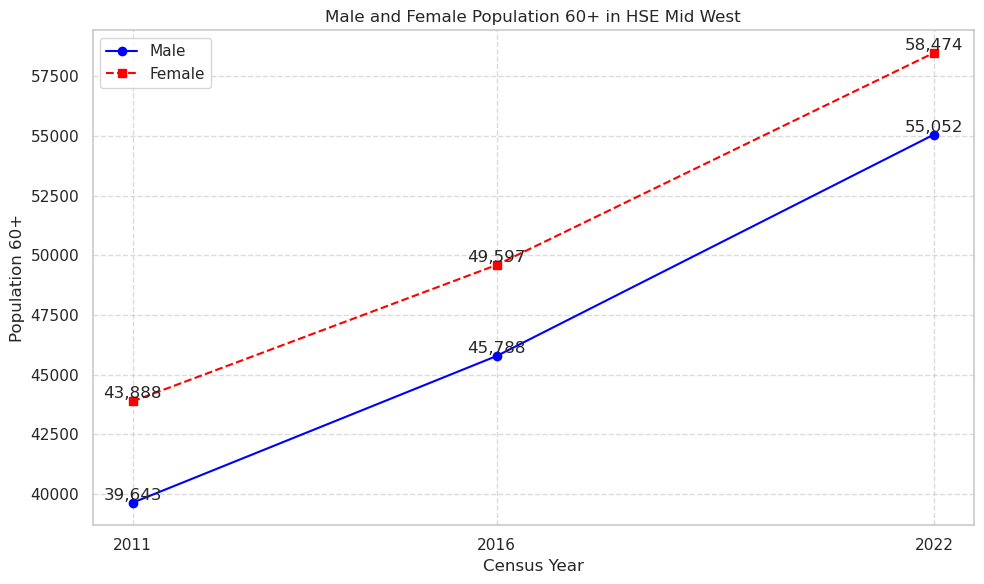

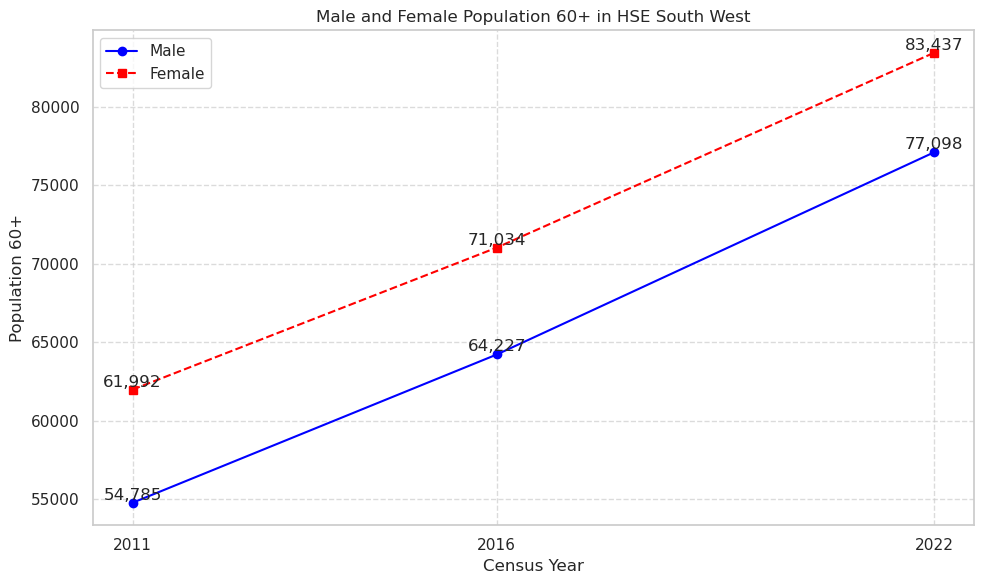

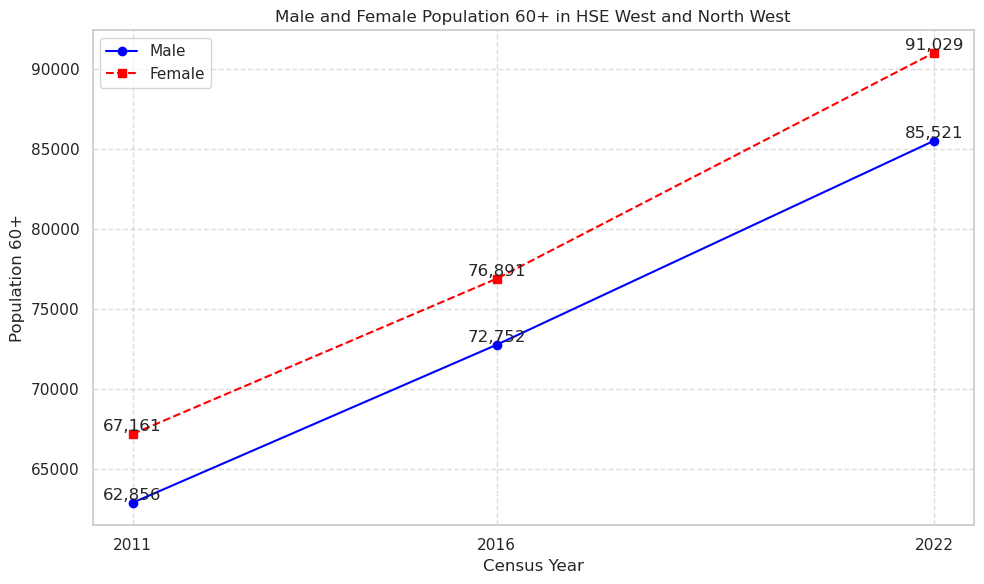

HSE Regions plotted:
- HSE Dublin and Midlands
- HSE Dublin and North East
- HSE Dublin and South East
- HSE Mid West
- HSE South West
- HSE West and North West


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate data by HSE Region, CensusYear, and Gender
df_aggregated = df_final.groupby(['HSE Region', 'CensusYear']).agg({
    'Male Population 60+': 'sum',
    'Female Population 60+': 'sum'
}).reset_index()

# Function to create a plot for a single HSE region
def plot_hse_region(region_data, region_name):
    plt.figure(figsize=(10, 6))
    
    # Plot male population
    plt.plot(region_data['CensusYear'], region_data['Male Population 60+'], 
             marker='o', linestyle='-', label='Male', color='blue')
    
    # Plot female population
    plt.plot(region_data['CensusYear'], region_data['Female Population 60+'], 
             marker='s', linestyle='--', label='Female', color='red')
    
    # Customize the plot
    plt.title(f'Male and Female Population 60+ in {region_name}')
    plt.xlabel('Census Year')
    plt.ylabel('Population 60+')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-axis to show only the census years
    plt.xticks(region_data['CensusYear'])
    
    # Add value labels
    for gender in ['Male Population 60+', 'Female Population 60+']:
        for year, pop in zip(region_data['CensusYear'], region_data[gender]):
            plt.text(year, pop, f'{pop:,.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Get unique HSE Regions and sort them
hse_regions = sorted(df_aggregated['HSE Region'].unique())

# Create a plot for each HSE region
for region in hse_regions:
    region_data = df_aggregated[df_aggregated['HSE Region'] == region]
    plot_hse_region(region_data, region)

# Print the list of HSE regions
print("HSE Regions plotted:")
for region in hse_regions:
    print(f"- {region}")

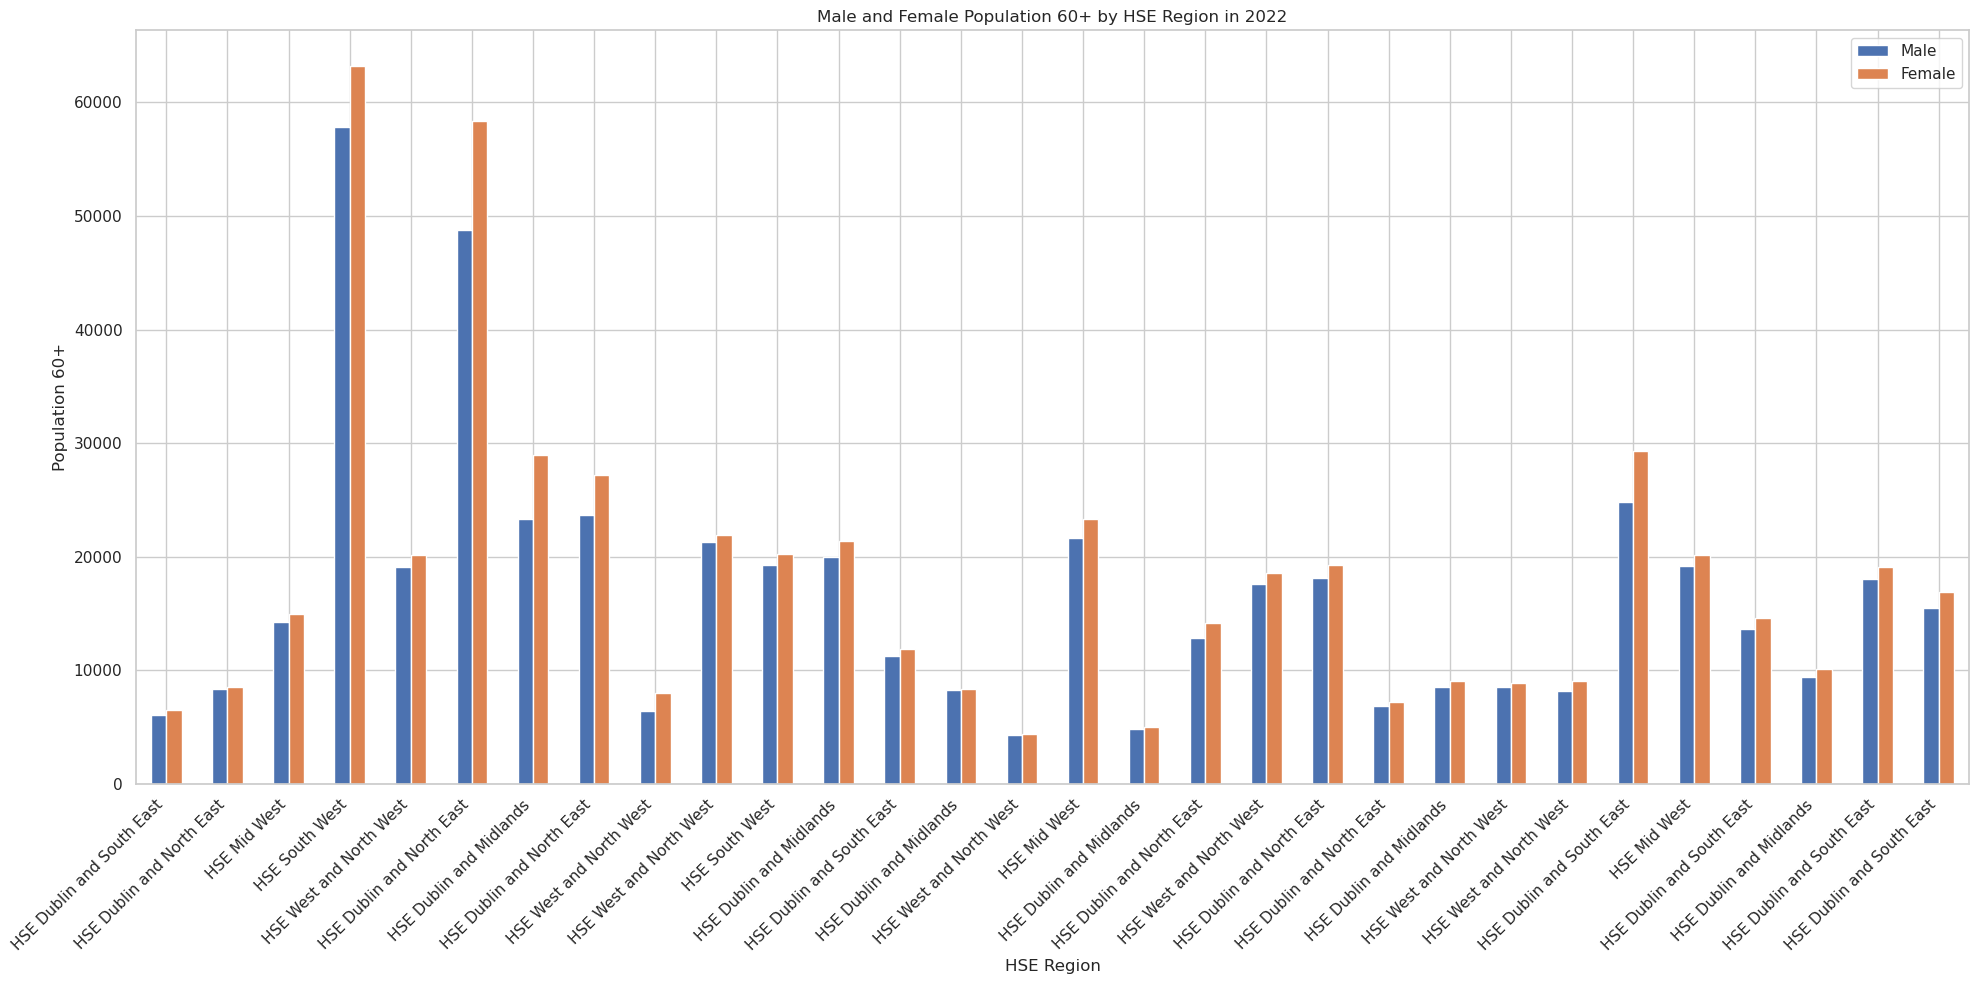

In [9]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
sns.set_style("whitegrid")

ax = df_2022.plot(x='HSE Region', 
                  y=['Male Population 60+', 'Female Population 60+'], 
                  kind='bar')

plt.title('Male and Female Population 60+ by HSE Region in 2022')
plt.xlabel('HSE Region')
plt.ylabel('Population 60+')
plt.xticks(rotation=45, ha='right')
plt.legend(['Male', 'Female'])
plt.tight_layout()
plt.show()

In [2]:
df_final.head(10)

,County and City,HSE Region,CensusYear,Male Population 60+,Female Population 60+,Total Population 60+
0,Carlow,HSE Dublin and South East,2011,4221,4570,8791
1,Carlow,HSE Dublin and South East,2016,4927,5294,10221
2,Carlow,HSE Dublin and South East,2022,6108,6518,12626
3,Cavan,HSE Dublin and North East,2011,6135,6255,12390
4,Cavan,HSE Dublin and North East,2016,7181,7196,14377
5,Cavan,HSE Dublin and North East,2022,8395,8563,16958
6,Clare,HSE Mid West,2011,10108,10827,20935
7,Clare,HSE Mid West,2016,11711,12583,24294
8,Clare,HSE Mid West,2022,14223,14966,29189
9,Cork City and Cork County,HSE South West,2011,40630,46697,87327


In [3]:
# Print data info
print(df_final.info())

# Print unique values in CensusYear
print("\nUnique values in CensusYear:")
print(df_final['CensusYear'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   County and City        90 non-null     object
 1   HSE Region             90 non-null     object
 2   CensusYear             90 non-null     int64 
 3   Male Population 60+    90 non-null     int64 
 4   Female Population 60+  90 non-null     int64 
 5   Total Population 60+   90 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 4.3+ KB
None

Unique values in CensusYear:
[2011 2016 2022]
